In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.2 MB/s eta 0:00:00


NLP Project Main Question:

Can we predict a player's next on ball movement?

Task: Predict the next event type in an NBA play-by-play sequence
(e.g., after this event, will the next one be a made shot, rebound, foul, turnover, etc.)

Input at time t: A graph of players in the current possession, with:

Nodes = players on court (in that possession)

Node features = player identity + whether they were P1/P2/P3 in the current event

Edges = interactions (if players co-occur as PLAYER1/2/3 in an event)

Label: The event type at time t+1 (mapped from EVENTMSGTYPE)

Model: A simple graph neural network in pure PyTorch
(no torch_geometric, you’re doing your own message passin

In [ ]:
# Import and configurations
import sys
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_geometric.nn import GATConv
from sklearn.metrics import accuracy_score, f1_score
import numpy as np


print("Python:", sys.version)
print("Torch:", torch.__version__)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available. Using GPU:", torch.cuda.get_device_name(0))
else:
    print("GPU not available. Using CPU.")


Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Torch: 2.9.0+cpu
Device: cpu
GPU not available. Using CPU.


In [ ]:
# Loading dataset
DATA_PATH = "/content/2000-01_pbp.csv"  # Corrected path


df = pd.read_csv(DATA_PATH)
df.head()

,Unnamed: 0,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,GAME_ID,HOMEDESCRIPTION,NEUTRALDESCRIPTION,PCTIMESTRING,PERIOD,PERSON1TYPE,...,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ABBREVIATION,PLAYER3_TEAM_CITY,PLAYER3_TEAM_ID,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VISITORDESCRIPTION,WCTIMESTRING
0,0,0,12,0,20001116,NaN,NaN,12:00,1,0.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12:11 PM
1,1,0,10,1,20001116,Jump Ball Grant vs. Mutombo: Tip to Hill,NaN,12:00,1,4.0,...,238,Tyrone Hill,PHI,Philadelphia,1.610613e+09,76ers,NaN,NaN,NaN,12:12 PM
2,2,1,1,2,20001116,NaN,NaN,11:45,1,5.0,...,0,NaN,NaN,NaN,NaN,NaN,2 - 0,-2,Iverson 21' Jump Shot (2 PTS),12:13 PM
3,3,1,6,3,20001116,NaN,NaN,11:28,1,5.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hill P.FOUL (P1.T1),12:13 PM
4,4,1,1,4,20001116,Mason 17' Jump Shot (2 PTS),NaN,11:19,1,4.0,...,0,NaN,NaN,NaN,NaN,NaN,2 - 2,TIE,NaN,12:13 PM


In [ ]:
df['EVENTMSGTYPE'].nunique()

13

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537157 entries, 0 to 537156
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 537157 non-null  int64  
 1   EVENTMSGACTIONTYPE         537157 non-null  int64  
 2   EVENTMSGTYPE               537157 non-null  int64  
 3   EVENTNUM                   537157 non-null  int64  
 4   GAME_ID                    537157 non-null  int64  
 5   HOMEDESCRIPTION            280199 non-null  object 
 6   NEUTRALDESCRIPTION         0 non-null       float64
 7   PCTIMESTRING               537157 non-null  object 
 8   PERIOD                     537157 non-null  int64  
 9   PERSON1TYPE                537156 non-null  float64
 10  PERSON2TYPE                537157 non-null  int64  
 11  PERSON3TYPE                537157 non-null  int64  
 12  PLAYER1_ID                 537157 non-null  int64  
 13  PLAYER1_NAME               48

In [ ]:
# Looking at column names to decide which to use
df.columns


Index(['Unnamed: 0', 'EVENTMSGACTIONTYPE', 'EVENTMSGTYPE', 'EVENTNUM',
       'GAME_ID', 'HOMEDESCRIPTION', 'NEUTRALDESCRIPTION', 'PCTIMESTRING',
       'PERIOD', 'PERSON1TYPE', 'PERSON2TYPE', 'PERSON3TYPE', 'PLAYER1_ID',
       'PLAYER1_NAME', 'PLAYER1_TEAM_ABBREVIATION', 'PLAYER1_TEAM_CITY',
       'PLAYER1_TEAM_ID', 'PLAYER1_TEAM_NICKNAME', 'PLAYER2_ID',
       'PLAYER2_NAME', 'PLAYER2_TEAM_ABBREVIATION', 'PLAYER2_TEAM_CITY',
       'PLAYER2_TEAM_ID', 'PLAYER2_TEAM_NICKNAME', 'PLAYER3_ID',
       'PLAYER3_NAME', 'PLAYER3_TEAM_ABBREVIATION', 'PLAYER3_TEAM_CITY',
       'PLAYER3_TEAM_ID', 'PLAYER3_TEAM_NICKNAME', 'SCORE', 'SCOREMARGIN',
       'VISITORDESCRIPTION', 'WCTIMESTRING'],
      dtype='object')

In [ ]:
import numpy as np
import pandas as pd

# ---------- vectorised side inference ----------
def infer_team_side_vec(df):
    has_home = df["HOMEDESCRIPTION"].fillna("").str.strip().astype(bool)
    has_vis  = df["VISITORDESCRIPTION"].fillna("").str.strip().astype(bool)

    # If both exist (rare), keep None so we fall back to prev_team
    both = has_home & has_vis
    side = np.select(
        [both, has_home, has_vis],
        [None, "HOME", "AWAY"],
        default=None
    )
    return side

df["SIDE"] = infer_team_side_vec(df)

# ---------- helpers ----------
def _safe_desc(row):
    return (
        (row["HOMEDESCRIPTION"] if isinstance(row["HOMEDESCRIPTION"], str) else "") + " " +
        (row["VISITORDESCRIPTION"] if isinstance(row["VISITORDESCRIPTION"], str) else "")
    ).lower()

def _is_final_ft(desc: str):
    # Covers typical pbp patterns
    return ("1 of 1" in desc) or ("2 of 2" in desc) or ("3 of 3" in desc)

def _ft_made(desc: str):
    # PBP often uses "MISS" for misses. "PTS" is not always reliable.
    return ("miss" not in desc)

# ---------- possession segmentation ----------
def segment_possessions(df):
    df = df.sort_values(["GAME_ID", "PERIOD", "EVENTNUM"]).reset_index(drop=True)

    df["POSSESSION_ID"] = 0
    df["OFFENSE_TEAM"]  = None

    possession = 0
    offense = None
    prev_team = None
    prev_game = None

    # used for "made FG" and "made final FT": flip NEXT event
    start_new_possession_next = False

    for i, row in df.iterrows():

        # --- new game reset ---
        if prev_game is None or row.GAME_ID != prev_game:
            possession = 0
            offense = None
            prev_team = None
            start_new_possession_next = False
        prev_game = row.GAME_ID

        event_type = int(row.EVENTMSGTYPE)
        side = row.SIDE
        desc = _safe_desc(row)

        # fallback side
        if side is None:
            side = prev_team
        if side is not None:
            prev_team = side

        # apply scheduled possession flip from prior made FG / made final FT
        if start_new_possession_next:
            possession += 1
            start_new_possession_next = False

        # ---------- start of period ----------
        if event_type == 12:
            # Don't auto-increment to 2.
            # Just ensure possession exists (start at 1 if this is the first meaningful event).
            if possession == 0:
                possession = 1
            offense = None
            df.at[i, "POSSESSION_ID"] = possession
            df.at[i, "OFFENSE_TEAM"]  = offense
            continue

        # ---------- jump ball ----------
        if event_type == 10:
            if possession == 0:
                possession = 1
            else:
                possession += 1
            offense = (prev_team if prev_team is not None else "HOME")
            offense = str(offense).strip().upper()
            df.at[i, "POSSESSION_ID"] = possession
            df.at[i, "OFFENSE_TEAM"]  = offense
            continue

        # init offense
        if offense is None and prev_team is not None:
            offense = prev_team
        if offense is not None:
            offense = str(offense).strip().upper()

        # write defaults
        df.at[i, "POSSESSION_ID"] = possession if possession != 0 else 1
        df.at[i, "OFFENSE_TEAM"]  = offense

        # ---------- made FG ----------
        if event_type == 1:
            # possession ends AFTER this event
            start_new_possession_next = True
            # offense flips next possession
            if offense is not None:
                offense = "AWAY" if offense == "HOME" else "HOME"
            continue

        # ---------- turnover ----------
        if event_type == 5:
            # turnover changes offense immediately, but possession boundary is next event
            turnover_team = side if side is not None else prev_team
            if turnover_team is not None:
                offense = "AWAY" if turnover_team == "HOME" else "HOME"
                offense = offense.strip().upper()
            start_new_possession_next = True
            continue

        # ---------- rebound ----------
        if event_type == 4:
            rebound_team = side if side is not None else prev_team
            if rebound_team is not None:
                rebound_team = rebound_team.strip().upper()
            # defensive rebound flips possession immediately
            if rebound_team is not None and offense is not None and rebound_team != offense:
                possession += 1
                offense = rebound_team
                df.at[i, "POSSESSION_ID"] = possession
                df.at[i, "OFFENSE_TEAM"]  = offense
            continue

        # ---------- free throws ----------
        if event_type == 3:
            # Only end possession on a MADE final FT.
            # If final FT is MISSED, possession ends when rebound happens (event_type==4).
            if _is_final_ft(desc) and _ft_made(desc):
                start_new_possession_next = True
                if offense is not None:
                    offense = "AWAY" if offense == "HOME" else "HOME"
                    offense = offense.strip().upper()
            continue

    missing = df["OFFENSE_TEAM"].isna().mean()
    print(f"Missing OFFENSE_TEAM fraction: {missing:.3f}")
    return df

df = segment_possessions(df)

# ---------- normalize to A/B ----------
def normalize_offense(x):
    if not isinstance(x, str):
        return None
    x = x.strip().upper()
    if x == "HOME":
        return "A"
    if x == "AWAY":
        return "B"
    return None

df["OFFENSE_TEAM"] = df["OFFENSE_TEAM"].apply(normalize_offense)


Missing OFFENSE_TEAM fraction: 0.009


In [ ]:
def normalize_offense(x):
    if x is None:
        return None
    x = str(x).strip().upper()

    if x in ("HOME", "H"):
        return "A"
    if x in ("AWAY", "V", "VISITOR", "VISITORS"):
        return "B"

    return None   # <— make sure to include this fallback

df["OFFENSE_TEAM"] = df["OFFENSE_TEAM"].apply(normalize_offense)



In [ ]:
df.loc[0:30, ['HOMEDESCRIPTION', 'VISITORDESCRIPTION', 'NEUTRALDESCRIPTION',
             'EVENTMSGTYPE', 'EVENTMSGACTIONTYPE', 'SCORE', 'POSSESSION_ID']]


,HOMEDESCRIPTION,VISITORDESCRIPTION,NEUTRALDESCRIPTION,EVENTMSGTYPE,EVENTMSGACTIONTYPE,SCORE,POSSESSION_ID
0,NaN,NaN,NaN,12,0,NaN,1
1,Jump Ball Camby vs. Ratliff: Tip to Houston,NaN,NaN,10,0,NaN,2
2,MISS Sprewell 6' Jump Shot,Ratliff BLOCK (1 BLK),NaN,2,1,NaN,2
3,NaN,76ers Rebound,NaN,4,0,NaN,3
4,Camby S.FOUL (P1.T1),NaN,NaN,6,2,NaN,3
5,NaN,Ratliff Free Throw 1 of 2 (1 PTS),NaN,3,11,1 - 0,3
6,NaN,MISS Ratliff Free Throw 2 of 2,NaN,3,12,NaN,3
7,Ward REBOUND (Off:0 Def:1),NaN,NaN,4,0,NaN,4
8,NaN,Ratliff S.FOUL (P1.T1),NaN,6,2,NaN,4
9,Camby Free Throw 1 of 2 (1 PTS),NaN,NaN,3,11,1 - 1,4


In [ ]:
def map_event_to_label(row):
    t = row["EVENTMSGTYPE"]

    if t == 1:  return "make_fg"
    if t == 2:  return "miss_fg"
    if t == 3:  return "free_throw"
    if t == 4:  return "rebound"
    if t == 5:  return "turnover"
    if t == 6:  return "foul"
    if t == 7:  return "violation"
    if t == 8:  return "substitution"
    if t == 9:  return "timeout"
    if t == 10: return "jumpball"
    if t == 11: return "ejection"
    if t == 12: return "start_period"

    return "other"


In [ ]:
df["ACTION_LABEL"] = df.apply(map_event_to_label, axis=1)

df["ACTION_LABEL"].value_counts()


,count
ACTION_LABEL,
rebound,121733
miss_fg,106799
make_fg,84865
free_throw,59138
foul,55134
substitution,43037
turnover,35785
timeout,15815
other,4858


In [ ]:
def build_player_to_team_map(df):
    """
    Build a mapping {player_id: team_id} using PLAYER*_ID and PLAYER*_TEAM_ID.
    """
    player_to_team = {}

    cols = [
        ("PLAYER1_ID", "PLAYER1_TEAM_ID"),
        ("PLAYER2_ID", "PLAYER2_TEAM_ID"),
        ("PLAYER3_ID", "PLAYER3_TEAM_ID"),
    ]

    for pid_col, tid_col in cols:
        temp = df[[pid_col, tid_col]].dropna()
        for pid, tid in temp.itertuples(index=False):
            pid = int(pid)
            tid = int(tid)
            if pid == 0 or tid == 0:
                continue

            if pid not in player_to_team:
                player_to_team[pid] = tid
            # Optional debug:
            # elif player_to_team[pid] != tid:
            #     print(f"Team mismatch for player {pid}: {player_to_team[pid]} vs {tid}")

    return player_to_team


In [ ]:
def infer_starting_lineups(game_df, player_to_team):
    """
    Infer starting 5 for both teams in this game based on earliest
    appearances in **period 1**.
    Returns (teamA_id, teamB_id, startersA, startersB).
    """
    if game_df.empty:
        return None, None, [], []

    # ------------------------------------------------------------------
    # 1. Restrict to period 1 and sort by event number
    # ------------------------------------------------------------------
    p1 = game_df[game_df["PERIOD"] == 1].sort_values("EVENTNUM")
    if p1.empty:
        print(f"⚠ Game {game_df['GAME_ID'].iloc[0]} has no period-1 data")
        return None, None, [], []

    # ------------------------------------------------------------------
    # 2. Identify the two team IDs quickly
    # ------------------------------------------------------------------
    team_cols = ["PLAYER1_TEAM_ID", "PLAYER2_TEAM_ID", "PLAYER3_TEAM_ID"]
    team_ids  = {int(t) for c in team_cols for t in p1[c].dropna() if int(t) != 0}
    if len(team_ids) != 2:
        print(f"⚠ Game {p1['GAME_ID'].iloc[0]} has {len(team_ids)} teams: {sorted(team_ids)}")
        return None, None, [], []

    teamA_id, teamB_id = sorted(team_ids)

    # ------------------------------------------------------------------
    # 3. Walk period 1 until 5 starters per team
    # ------------------------------------------------------------------
    startersA, startersB = [], []
    for _, row in p1.iterrows():
        pid = row["PLAYER1_ID"]
        if pd.isna(pid) or pid == 0:
            continue

        pid = int(pid)
        tid = player_to_team.get(pid)
        if tid is None:
            continue

        if tid == teamA_id and pid not in startersA:
            startersA.append(pid)
        elif tid == teamB_id and pid not in startersB:
            startersB.append(pid)

        if len(startersA) >= 5 and len(startersB) >= 5:
            break

    if len(startersA) < 5 or len(startersB) < 5:
        gid = p1["GAME_ID"].iloc[0]
        print(f"⚠ Game {gid} incomplete starters (A:{len(startersA)}, B:{len(startersB)})")

    return teamA_id, teamB_id, startersA[:5], startersB[:5]

In [ ]:
def add_oncourt_players(df, player_to_team):
    df = df.sort_values(["GAME_ID", "PERIOD", "EVENTNUM"]).reset_index(drop=True)
    df["ONCOURT_TEAM_A"] = None
    df["ONCOURT_TEAM_B"] = None

    # Pre-compute player→team once (vectorised)
    pid_all = pd.Series(player_to_team.keys())
    tid_all = pd.Series(player_to_team.values())
    pid_to_tid = dict(zip(pid_all, tid_all))   # fast lookup

    for game_id, game_df in df.groupby("GAME_ID", sort=False):

        game_df = game_df.sort_values(["PERIOD", "EVENTNUM"])
        teamA_id, teamB_id, startersA, startersB = infer_starting_lineups(game_df, player_to_team)
        if teamA_id is None:
            continue

        teamA_on = set(startersA)
        teamB_on = set(startersB)

        for _, row in game_df.iterrows():
            idx = row.name          # original df index

            # store PRE-substitution lineup
            df.at[idx, "ONCOURT_TEAM_A"] = list(teamA_on)
            df.at[idx, "ONCOURT_TEAM_B"] = list(teamB_on)

            if row["EVENTMSGTYPE"] != 8:        # not a sub
                continue

            out_id = row["PLAYER1_ID"]
            in_id  = row["PLAYER2_ID"]

            if pd.isna(out_id) | pd.isna(in_id):
                continue
            out_id = int(out_id)
            in_id  = int(in_id)

            team_out = pid_to_tid.get(out_id)
            team_in  = pid_to_tid.get(in_id)

            # perform sub
            if team_out == teamA_id:
                teamA_on.discard(out_id)
                teamA_on.add(in_id)
            elif team_out == teamB_id:
                teamB_on.discard(out_id)
                teamB_on.add(in_id)
            elif team_in == teamA_id:          # fallback
                teamA_on.add(in_id)
            elif team_in == teamB_id:
                teamB_on.add(in_id)

            # ALWAYS enforce 5-man roster
            if len(teamA_on) > 5:
                teamA_on = set(sorted(teamA_on)[:5])
            if len(teamB_on) > 5:
                teamB_on = set(sorted(teamB_on)[:5])

    return df

In [ ]:
def build_player_to_team_map(df):
    """
    Return dict {player_id: team_id} from PLAYER1/2/3 columns.
    Drops pid=0 or tid=0 and keeps first mapping only.
    """
    mapping = {}
    cols = [("PLAYER1_ID", "PLAYER1_TEAM_ID"),
            ("PLAYER2_ID", "PLAYER2_TEAM_ID"),
            ("PLAYER3_ID", "PLAYER3_TEAM_ID")]

    for pid_col, tid_col in cols:
        chunk = df[[pid_col, tid_col]].dropna()
        chunk = chunk[(chunk[pid_col] != 0) & (chunk[tid_col] != 0)]  # drop bad IDs
        for pid, tid in chunk.itertuples(index=False):
            mapping.setdefault(int(pid), int(tid))   # first encounter wins

    return mapping

player_to_team = build_player_to_team_map(df)

print(f"Unique players: {len(player_to_team):,}")
print("First 10 mappings:", list(player_to_team.items())[:10])

# quick guard
assert len(player_to_team) > 400, "Too few players — check data load"

Unique players: 441
First 10 mappings: [(948, 1610612752), (84, 1610612752), (689, 1610612755), (369, 1610612752), (947, 1610612755), (275, 1610612752), (238, 1610612755), (248, 1610612755), (727, 1610612755), (913, 1610612752)]


In [ ]:
df = add_oncourt_players(df, player_to_team)

# ---------- quick health check ----------
print("Games with on-court data:", df["ONCOURT_TEAM_A"].notna().sum())
print("Sample row:")
display(df[['GAME_ID', 'EVENTNUM', 'ONCOURT_TEAM_A', 'ONCOURT_TEAM_B']].head())

# optional strict guard
# assert df["ONCOURT_TEAM_A"].notna().sum() > 0, "No on-court data generated"

⚠ Game 20000375 incomplete starters (A:6, B:4)
⚠ Game 20000700 incomplete starters (A:4, B:8)
⚠ Game 20000794 incomplete starters (A:4, B:6)
⚠ Game 20000817 incomplete starters (A:8, B:4)
⚠ Game 20000821 incomplete starters (A:4, B:5)
⚠ Game 20000824 incomplete starters (A:4, B:5)
⚠ Game 20000844 incomplete starters (A:8, B:4)
⚠ Game 20000855 incomplete starters (A:4, B:6)
⚠ Game 20000879 incomplete starters (A:4, B:6)
⚠ Game 20000880 incomplete starters (A:5, B:4)
⚠ Game 20000888 incomplete starters (A:8, B:4)
⚠ Game 20000894 incomplete starters (A:4, B:8)
⚠ Game 20000903 incomplete starters (A:4, B:8)
⚠ Game 20000926 incomplete starters (A:3, B:6)
⚠ Game 20000945 incomplete starters (A:4, B:7)
⚠ Game 20000951 incomplete starters (A:6, B:4)
⚠ Game 20000953 incomplete starters (A:3, B:7)
⚠ Game 20000954 incomplete starters (A:4, B:7)
⚠ Game 20000970 incomplete starters (A:8, B:4)
⚠ Game 20000972 incomplete starters (A:4, B:7)
⚠ Game 20000983 incomplete starters (A:6, B:4)
⚠ Game 200009

,GAME_ID,EVENTNUM,ONCOURT_TEAM_A,ONCOURT_TEAM_B
0,20000001,0,"[369, 913, 275, 948, 84]","[238, 689, 947, 727, 248]"
1,20000001,1,"[369, 913, 275, 948, 84]","[238, 689, 947, 727, 248]"
2,20000001,2,"[369, 913, 275, 948, 84]","[238, 689, 947, 727, 248]"
3,20000001,3,"[369, 913, 275, 948, 84]","[238, 689, 947, 727, 248]"
4,20000001,4,"[369, 913, 275, 948, 84]","[238, 689, 947, 727, 248]"


In [ ]:
df_sub = df[df["EVENTMSGTYPE"] == 8][[
    "GAME_ID", "PERIOD", "EVENTNUM",
    "HOMEDESCRIPTION", "VISITORDESCRIPTION",
    "PLAYER1_ID", "PLAYER2_ID",
    "ONCOURT_TEAM_A", "ONCOURT_TEAM_B"
]]

df_sub.head(10)



,GAME_ID,PERIOD,EVENTNUM,HOMEDESCRIPTION,VISITORDESCRIPTION,PLAYER1_ID,PLAYER2_ID,ONCOURT_TEAM_A,ONCOURT_TEAM_B
66,20000001,1,67,NaN,SUB: McKie FOR Hill,238,243,"[369, 913, 275, 948, 84]","[238, 689, 947, 727, 248]"
68,20000001,1,69,SUB: Childs FOR Ward,NaN,369,164,"[369, 913, 275, 948, 84]","[689, 947, 243, 727, 248]"
73,20000001,1,74,SUB: Rice FOR Sprewell,NaN,84,779,"[164, 913, 275, 948, 84]","[689, 947, 243, 727, 248]"
79,20000001,1,80,SUB: Thomas FOR Camby,NaN,948,703,"[164, 779, 913, 275, 948]","[689, 947, 243, 727, 248]"
88,20000001,1,90,NaN,SUB: Maxwell FOR McKie,243,137,"[164, 779, 913, 275, 703]","[689, 947, 243, 727, 248]"
89,20000001,1,91,NaN,SUB: MacCulloch FOR Ratliff,689,1928,"[164, 779, 913, 275, 703]","[137, 689, 947, 727, 248]"
92,20000001,1,94,NaN,SUB: McKie FOR Snow,727,243,"[164, 779, 913, 275, 703]","[1928, 137, 947, 727, 248]"
124,20000001,2,127,NaN,SUB: Snow FOR Iverson,947,727,"[164, 779, 913, 275, 703]","[1928, 137, 947, 243, 248]"
134,20000001,2,137,NaN,SUB: Iverson FOR Maxwell,137,947,"[164, 779, 913, 275, 703]","[1928, 137, 243, 727, 248]"
140,20000001,2,144,NaN,SUB: Maxwell FOR Snow,727,137,"[164, 779, 913, 275, 703]","[1928, 947, 243, 727, 248]"


In [ ]:
def build_edges_10player(event_row, players):
    """
    Always returns:
      edge_index: LongTensor [2, E]
      edge_attr : FloatTensor [E]
    """
    n = len(players)

    # If not exactly 10, return empty but VALID shape
    if n == 0:
        edge_index = torch.zeros((2, 0), dtype=torch.long)
        edge_attr  = torch.zeros((0,), dtype=torch.float)
        return edge_index, edge_attr

    pid2idx = {int(p): i for i, p in enumerate(players) if p is not None}
    edges = []

    def valid(pid):
        return pid is not None and pid != 0 and int(pid) in pid2idx

    p1 = event_row.get("PLAYER1_ID")
    p2 = event_row.get("PLAYER2_ID")
    p3 = event_row.get("PLAYER3_ID")

    for a, b in ((p1, p2), (p1, p3)):
        if valid(a) and valid(b):
            ia, ib = pid2idx[int(a)], pid2idx[int(b)]
            edges.append((ia, ib))
            edges.append((ib, ia))

    # Always add self-loops for all players
    for i in range(n):
        edges.append((i, i))

    # Convert to tensors
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()  # [2, E]

    # Weight logic (optional)
    desc = (str(event_row.get("HOMEDESCRIPTION") or "") + " " +
            str(event_row.get("VISITORDESCRIPTION") or "")).lower()

    weight_map = {"assist": 3.0, "block": 3.0, "steal": 2.0, "rebound": 1.5, "foul": 1.2}
    base_weight = 1.0
    for k, v in weight_map.items():
        if k in desc:
            base_weight = v
            break

    edge_attr = torch.full((edge_index.size(1),), float(base_weight), dtype=torch.float)

    # FINAL GUARANTEE
    if edge_index.dim() != 2 or edge_index.size(0) != 2:
        raise ValueError(f"Bad edge_index built: shape={tuple(edge_index.shape)}")

    return edge_index, edge_attr


In [ ]:
# ---------- collect player IDs ----------
pids = (pd.concat([df[col] for col in ["PLAYER1_ID", "PLAYER2_ID", "PLAYER3_ID"]])
          .dropna()
          .astype(int))
pids = pids[pids != 0]
pids = pids[pids < 1_000_000]                # NBA team IDs ≥ 1 610 613 xxx

# add on-court players
on_a = pd.Series([pid for lst in df["ONCOURT_TEAM_A"] if isinstance(lst, list) for pid in lst])
on_b = pd.Series([pid for lst in df["ONCOURT_TEAM_B"] if isinstance(lst, list) for pid in lst])
pids = pd.concat([pids, on_a, on_b]).dropna().astype(int)

all_player_ids = sorted(pids.unique())
num_players_total = len(all_player_ids)

# ---------- embedding lookup ----------
player_to_emb = {pid: idx for idx, pid in enumerate(all_player_ids)}
assert len(player_to_emb) == num_players_total
assert num_players_total > 0, "No players collected"

print("Total players found:", num_players_total)

Total players found: 489


In [ ]:
embedding_dim = 128

unique_evt = sorted(df.EVENTMSGTYPE.unique())
evt_to_idx = {evt: i for i, evt in enumerate(unique_evt)}
df["EVENTMSGTYPE_IDX"] = df.EVENTMSGTYPE.map(evt_to_idx)

num_event_types = len(unique_evt)

assert df["EVENTMSGTYPE_IDX"].isna().sum() == 0


In [ ]:
def extract_context_features(event_row, prev_row=None):
    # --- Time remaining ---
    try:
        mm, ss = str(event_row.get("PCTIMESTRING", "0:00")).split(":")
        time_left = int(mm) * 60 + int(ss)
    except:
        time_left = 0
    time_left_norm = time_left / 720.0

    # --- Current score margin ---
    try:
        margin_raw = str(event_row.get("SCOREMARGIN", "0"))
        if margin_raw.upper() in ("TIE", "-", "") or pd.isna(margin_raw):
            curr_margin = 0.0
        else:
            curr_margin = float(margin_raw)
    except:
        curr_margin = 0.0

    # --- Previous score margin ---
    try:
        prev_margin_raw = str(prev_row.get("SCOREMARGIN", "0")) if prev_row is not None else "0"
        if prev_margin_raw.upper() in ("TIE", "-", "") or pd.isna(prev_margin_raw):
            prev_margin = 0.0
        else:
            prev_margin = float(prev_margin_raw)
    except:
        prev_margin = 0.0

    margin_norm = max(min(curr_margin / 20.0, 1.0), -1.0)
    momentum = max(min((curr_margin - prev_margin) / 20.0, 1.0), -1.0)

    # --- Period normalized ---
    try:
        period_norm = float(event_row.get("PERIOD", 1)) / 4.0
    except:
        period_norm = 0.0

    # --- Is home possession ---
    home_desc = event_row.get("HOMEDESCRIPTION", "")
    is_home = 1.0 if isinstance(home_desc, str) and home_desc.strip() else 0.0

    # --- Shot-clock proxy ---
    if prev_row is not None:
        try:
            mm0, ss0 = str(prev_row.get("PCTIMESTRING", "0:00")).split(":")
            prev_time = int(mm0) * 60 + int(ss0)
            dt = prev_time - time_left
            shot_clock = dt / 24.0 if 0 <= dt <= 24 else 0.0
        except:
            shot_clock = 0.0
    else:
        shot_clock = 0.0

    feat = torch.tensor(
        [time_left_norm, margin_norm, period_norm, is_home, shot_clock, momentum],
        dtype=torch.float
    )

    return torch.nan_to_num(feat, nan=0.0, posinf=0.0, neginf=0.0)


In [ ]:
def build_graph_for_event(event_row, prev_row, poss_progress):
    """
    Build a single graph snapshot for one event.
    """
    # ON COURT PLAYERS (always 10)
    players = event_row["ONCOURT_TEAM_A"] + event_row["ONCOURT_TEAM_B"]
    players = [int(p) for p in players if p is not None]

    # Build edges
    edge_index, edge_weight = build_edges_10player(event_row, players)

    return {
        "on_court": players,
        "event_row": event_row.to_dict(),
        "prev_row": None if prev_row is None else prev_row.to_dict(),
        "poss_progress": poss_progress,
        "edge_index": (edge_index, edge_weight)
    }


In [ ]:
def infer_team_side(row):
    desc = (
        (row["HOMEDESCRIPTION"] if pd.notna(row["HOMEDESCRIPTION"]) else "") + " " +
        (row["VISITORDESCRIPTION"] if pd.notna(row["VISITORDESCRIPTION"]) else "")
    ).lower()

    if "makes" in desc or "misses" in desc or "turnover" in desc or "foul" in desc:
        if "home" in desc:
            return "A"
        if "visitor" in desc or "away" in desc:
            return "B"
    return None


In [ ]:
from collections import defaultdict, deque

ROLL_WINDOW = 20

rolling_form = defaultdict(lambda: {
    "fg_made": deque(maxlen=ROLL_WINDOW),
    "fg_att":  deque(maxlen=ROLL_WINDOW),
    "tp_made": deque(maxlen=ROLL_WINDOW),
    "tp_att":  deque(maxlen=ROLL_WINDOW),
    "touches": deque(maxlen=ROLL_WINDOW),
})


In [ ]:
def update_rolling_form(row):
    pid = row.get("PLAYER1_ID")
    if pid is None or pid == 0:
        return

    f = rolling_form[int(pid)]

    event_type = row["EVENTMSGTYPE"]
    desc = (str(row.get("HOMEDESCRIPTION") or "") +
            str(row.get("VISITORDESCRIPTION") or "")).lower()

    # FG attempt
    if event_type == 1:
        made = "pts" in desc
        is_three = "3pt" in desc

        f["fg_att"].append(1)
        f["fg_made"].append(1 if made else 0)

        if is_three:
            f["tp_att"].append(1)
            f["tp_made"].append(1 if made else 0)

    # Usage proxy
    if event_type in {1, 2, 5, 6}:
        f["touches"].append(1)


In [ ]:
def build_graphs_for_possession(poss_df):
    poss_df = poss_df.sort_values("EVENTNUM").reset_index(drop=True)

    if len(poss_df) < 2:
        return [], []

    graphs, labels = [], []

    offense_team = poss_df.iloc[0].get("OFFENSE_TEAM", None)
    hist = deque(maxlen=3)
    sub_time = {}

    for i in range(len(poss_df) - 1):
        row      = poss_df.iloc[i]
        next_row = poss_df.iloc[i + 1]
        prev_row = poss_df.iloc[i - 1] if i > 0 else None

        history_snapshot = list(hist)

        if row["EVENTMSGTYPE"] == 8 and not pd.isna(row["PLAYER2_ID"]):
            sub_time[int(row["PLAYER2_ID"])] = row["PCTIMESTRING"]

        teamA = row["ONCOURT_TEAM_A"]
        teamB = row["ONCOURT_TEAM_B"]
        if not (isinstance(teamA, list) and isinstance(teamB, list)):
            continue

        players = teamA + teamB
        if len(players) != 10:
            continue

        poss_progress = i / max(len(poss_df) - 1, 1)

        if row.get("OFFENSE_TEAM") is not None:
            offense_team = row["OFFENSE_TEAM"]

        edge_index, edge_attr = build_edges_10player(row.to_dict(), players)

        graph = {
            "event_row": row.to_dict(),
            "prev_row": None if prev_row is None else prev_row.to_dict(),
            "poss_progress": poss_progress,
            "edge_index": edge_index,
            "edge_attr": edge_attr,
            "offense_team": offense_team,
            "history": history_snapshot,
            "sub_time": sub_time.copy(),

            # 🔥 THIS is the key
            "rolling_form": {p: dict(rolling_form[p]) for p in players}
        }



        graphs.append(graph)
        labels.append(next_row["ACTION_LABEL"])
        hist.append(row["EVENTMSGTYPE"])

    return graphs, labels


In [ ]:
  from collections import deque

  all_graphs = []
  all_labels = []

  for (game_id, poss_id), poss_df in df.groupby(["GAME_ID", "POSSESSION_ID"]):
      poss_df = poss_df.sort_values("EVENTNUM").reset_index(drop=True)

      g_list, y_list = build_graphs_for_possession(poss_df)

      if len(g_list) == 0:
          continue

      all_graphs.extend(g_list)
      all_labels.extend(y_list)

  print("Total graphs:", len(all_graphs))
  print("Total labels:", len(all_labels))
  print("Unique labels:", set(all_labels))


Total graphs: 214613
Total labels: 214613
Unique labels: {'foul', 'make_fg', 'miss_fg', 'other', 'start_period', 'violation', 'turnover', 'ejection', 'timeout', 'substitution', 'rebound', 'free_throw'}


In [ ]:
unique_labels = sorted(set(all_labels))
label_to_idx = {lab: i for i, lab in enumerate(unique_labels)}

num_classes = len(label_to_idx)

print(label_to_idx)
print("Num classes:", num_classes)


{'ejection': 0, 'foul': 1, 'free_throw': 2, 'make_fg': 3, 'miss_fg': 4, 'other': 5, 'rebound': 6, 'start_period': 7, 'substitution': 8, 'timeout': 9, 'turnover': 10, 'violation': 11}
Num classes: 12


In [ ]:
# ------------------------------------------------------------------
# 1.  train / validation split (BY GAME_ID — no leakage)
# ------------------------------------------------------------------
from sklearn.model_selection import train_test_split
import numpy as np

# Extract GAME_ID for each graph
graph_game_ids = [g["event_row"]["GAME_ID"] for g in all_graphs]

# Unique games
unique_games = np.unique(graph_game_ids)

# Split games (NOT graphs)
train_games, val_games = train_test_split(
    unique_games,
    test_size=0.2,
    random_state=42
)

train_games = set(train_games)
val_games   = set(val_games)

# Map back to graph indices
train_idx = [i for i, gid in enumerate(graph_game_ids) if gid in train_games]
val_idx   = [i for i, gid in enumerate(graph_game_ids) if gid in val_games]

print(f"Train games: {len(train_games)}, Val games: {len(val_games)}")
print(f"Train graphs: {len(train_idx)}, Val graphs: {len(val_idx)}")

# Build splits
train_graphs = [all_graphs[i] for i in train_idx]
train_labels = [all_labels[i] for i in train_idx]
val_graphs   = [all_graphs[i] for i in val_idx]
val_labels   = [all_labels[i] for i in val_idx]


Train games: 948, Val games: 237
Train graphs: 172491, Val graphs: 42122


In [ ]:
class GATModel(nn.Module):
    def __init__(self, hidden_dim, num_classes, heads=4):
        super().__init__()

        self.heads = heads

        self.player_embedding = nn.Embedding(num_players_total, embedding_dim)
        self.event_embedding  = nn.Embedding(num_event_types, 8)

        self.hist_event_emb = nn.Embedding(num_event_types + 1, 3)
        self.hist_pad_idx   = num_event_types

        # Correct feature dim:

        self.in_dim = 162

        self.gat1 = GATConv(
            self.in_dim,
            hidden_dim,
            heads=self.heads,
            concat=False,
            add_self_loops=False   # 🔥 IMPORTANT
        )
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.drop1 = nn.Dropout(0.2)

        self.gat2 = GATConv(
            hidden_dim,
            hidden_dim,
            heads=self.heads,
            concat=False,
            add_self_loops=False
        )
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.drop2 = nn.Dropout(0.2)

        self.gat3 = GATConv(
            hidden_dim,
            hidden_dim,
            heads=self.heads,
            concat=False,
            add_self_loops=False
        )
        self.norm3 = nn.LayerNorm(hidden_dim)
        self.drop3 = nn.Dropout(0.2)

        self.lin1 = nn.Linear(hidden_dim, hidden_dim)
        self.drop_lin = nn.Dropout(0.2)
        self.lin2 = nn.Linear(hidden_dim, num_classes)

    def _safe_clock_to_sec(self, s):
        try:
            mm, ss = str(s).split(":")
            return int(mm) * 60 + int(ss)
        except:
            return 0

    def build_node_features_10player(self, event_row, prev_row, poss_progress, offense_team, sub_time):
        device = next(self.parameters()).device

        teamA = event_row["ONCOURT_TEAM_A"]
        teamB = event_row["ONCOURT_TEAM_B"]
        players = [int(p) for p in (teamA + teamB) if p is not None]

        # ---- 3-step history (embedded) ----
        hist_ids = [int(x) for x in event_row.get("history", [])[-3:]]
        while len(hist_ids) < 3:
            hist_ids.insert(0, self.hist_pad_idx)
        hist_ids = [h if 0 <= h < num_event_types else self.hist_pad_idx for h in hist_ids]

        hist_emb = self.hist_event_emb(torch.tensor(hist_ids, device=device)).reshape(-1)  # (9,)

        # ---- context features (already nan_to_num in your updated version) ----
        context_feats = extract_context_features(event_row, prev_row).to(device)  # (6,)

        # ---- event embedding ----
        evt_emb = self.event_embedding(torch.tensor(int(event_row["EVENTMSGTYPE_IDX"]), device=device))  # (8,)

        # ---- tempo ----
        if prev_row is None:
            tempo = torch.tensor([0.0], device=device)
        else:
            t_now  = self._safe_clock_to_sec(event_row.get("PCTIMESTRING", "0:00"))
            t_prev = self._safe_clock_to_sec(prev_row.get("PCTIMESTRING", "0:00"))
            tempo = torch.tensor([abs(t_now - t_prev) / 720.0], device=device)

        progress = torch.tensor([float(poss_progress)], device=device)

        act = [int(event_row.get(f"PLAYER{i}_ID", 0)) for i in (1, 2, 3)]

        feats = []
        for p in players:
            p_emb = self.player_embedding(torch.tensor(player_to_emb[p], device=device))  # (128,)

            role = torch.tensor([float(p == act[i]) for i in range(3)], device=device)  # (3,)

            is_off = 1.0 if (
                (offense_team == "A" and p in teamA) or
                (offense_team == "B" and p in teamB)
            ) else 0.0
            offdef = torch.tensor([is_off, 1.0 - is_off], device=device)  # (2,)

            rf = event_row.get("rolling_form", {})

            f = rf.get(p, {
                "fg_made": [],
                "fg_att": [],
                "tp_made": [],
                "tp_att": [],
                "touches": []
            })

            def safe_ratio(made, att):
                return float(made / att) if att > 0 else 0.0

            fg_pct = safe_ratio(sum(f["fg_made"]), sum(f["fg_att"]))
            tp_pct = safe_ratio(sum(f["tp_made"]), sum(f["tp_att"]))
            usg    = min(len(f["touches"]) / ROLL_WINDOW, 1.0)

            form = torch.tensor([fg_pct, tp_pct, usg], device=device)
            form = torch.nan_to_num(form, nan=0.0, posinf=0.0, neginf=0.0)

            def sanitize_float(v):
                return 0.0 if (np.isnan(v) or np.isinf(v)) else float(v)

            # Option B: disable rolling form for now
            form = torch.zeros(3, device=device)


            # ---- load ----
            game_sec = self._safe_clock_to_sec(event_row.get("PCTIMESTRING", "0:00"))
            check_in = sub_time.get(p, "24:00")
            in_sec = self._safe_clock_to_sec(check_in)

            raw_load = max(0.0, (game_sec - in_sec) / 60.0 / 48.0)
            if np.isnan(raw_load) or np.isinf(raw_load):
                raw_load = 0.0
            load = torch.tensor([raw_load], device=device)  # (1,)

            feat = torch.cat([
                p_emb, role, offdef, context_feats, evt_emb,
                tempo, progress, form, hist_emb, load
            ])


            # Hard clamp
            feat = torch.nan_to_num(feat, nan=0.0, posinf=0.0, neginf=0.0)

            feats.append(feat)

        x = torch.stack(feats)

        # Fail-fast once per graph build
        if x.size(1) != self.in_dim:
            raise ValueError(f"Feature dim mismatch: got {x.size(1)} expected {self.in_dim}")

        if torch.isnan(x).any():
            raise ValueError("NaN detected in node features")

        return x

    def forward(self, batch):
        from torch_geometric.nn import global_mean_pool

        h = batch.x
        h = torch.nan_to_num(h, nan=0.0, posinf=0.0, neginf=0.0)

        # GAT → Norm → Activation
        h = self.gat1(h, batch.edge_index)
        h = self.norm1(h)
        h = F.gelu(h)

        h = self.gat2(h, batch.edge_index)
        h = self.norm2(h)
        h = F.gelu(h)

        h = self.gat3(h, batch.edge_index)
        h = self.norm3(h)
        h = F.gelu(h)

        graph_emb = global_mean_pool(h, batch.batch)
        out = self.lin2(self.drop_lin(F.gelu(self.lin1(graph_emb))))
        return out, batch.y



In [ ]:
# --------------------------------------------------
# Model instantiation
# --------------------------------------------------
hidden_dim = 128   # or whatever you chose
heads = 4

model = GATModel(
    hidden_dim=hidden_dim,
    num_classes=num_classes,
    heads=heads
)

model = model.to(device)


In [ ]:
from torch_geometric.data import Data

@torch.no_grad()
def graph_to_data(g, label_to_idx, model, device):
    x = model.build_node_features_10player(
        g["event_row"],
        g["prev_row"],
        g["poss_progress"],
        g["offense_team"],
        g["sub_time"]
    )

    y = torch.tensor(label_to_idx[g["y"]], dtype=torch.long)

    edge_index = g["edge_index"]
    edge_attr  = g["edge_attr"]

    # HARD CHECK
    if edge_index.dim() != 2 or edge_index.size(0) != 2:
        raise ValueError(f"Bad edge_index entering Data: {tuple(edge_index.shape)}")

    # Keep CPU tensors in Data; move batch to GPU in training loop via batch.to(device)
    return Data(
        x=x.cpu(),
        edge_index=edge_index.cpu(),
        edge_attr=edge_attr.cpu(),
        y=y
    )


In [ ]:
def build_dataset(graph_list, labels, label_to_idx, model, device):
    data_list = []
    for g, lab in zip(graph_list, labels):
        g["y"] = lab
        data_list.append(graph_to_data(g, label_to_idx, model, device))
    return data_list


In [ ]:
from torch_geometric.loader import DataLoader as PyGDataLoader
# --------------------------------------------------
# Build PyG datasets (USES THE MODEL)
# --------------------------------------------------
train_data = build_dataset(
    train_graphs,
    train_labels,
    label_to_idx,
    model,
    device
)

val_data = build_dataset(
    val_graphs,
    val_labels,
    label_to_idx,
    model,
    device
)

print("Train dataset size:", len(train_data))
print("Val dataset size:", len(val_data))

# DataLoaders

train_loader = PyGDataLoader(
    train_data,
    batch_size=256,
    shuffle=True,
    num_workers=0   # required on Colab
)

val_loader = PyGDataLoader(
    val_data,
    batch_size=256,
    shuffle=False,
    num_workers=0
)


Train dataset size: 172491
Val dataset size: 42122


In [ ]:
import torch
import pandas as pd

# train_labels: list of raw labels (strings or ints)
# label_to_idx: mapping {label -> class_index}
num_classes = len(label_to_idx)

# Convert train labels to class indices
train_label_idxs = torch.tensor(
    [label_to_idx[y] for y in train_labels],
    dtype=torch.long
)

# Count samples per class
class_counts = torch.bincount(
    train_label_idxs,
    minlength=num_classes
).float()

# Total number of samples
total_samples = class_counts.sum()

# Compute inverse-frequency weights
class_weights = total_samples / (num_classes * class_counts)

# Replace inf / nan (for safety)
class_weights = torch.nan_to_num(
    class_weights,
    nan=0.0,
    posinf=0.0,
    neginf=0.0
)

# Move to device
class_weights = class_weights.to(device)

print("Class counts :", class_counts.tolist())
print("Class weights:", class_weights.tolist())


Class counts : [64.0, 15365.0, 31713.0, 26483.0, 32740.0, 1856.0, 24491.0, 2059.0, 20586.0, 4151.0, 12334.0, 649.0]
Class weights: [224.59765625, 0.9355190396308899, 0.45326048135757446, 0.5427727103233337, 0.43904244899749756, 7.744746685028076, 0.5869196653366089, 6.981180191040039, 0.6982536911964417, 3.4628403186798096, 1.1654167175292969, 22.148305892944336]


In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import GradScaler


# AMP
use_amp = (device.type == "cuda")
scaler = GradScaler(enabled=use_amp)


num_epochs = 50
warmup_epochs = 3

base_lr = 1e-4

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=base_lr,
    weight_decay=1e-5
)

scheduler = CosineAnnealingLR(
    optimizer,
    T_max=num_epochs - warmup_epochs,
    eta_min=base_lr * 0.05
)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device, scaler, epoch, warmup_epochs, base_lr):
    model.train()
    total_loss = 0.0
    total_graphs = 0

    use_amp = device.type == "cuda"

    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad(set_to_none=True)

        # ---- forward ----
        if use_amp:
            with torch.cuda.amp.autocast():
                logits, labels = model(batch)
                loss = criterion(logits, labels)
        else:
            logits, labels = model(batch)
            loss = criterion(logits, labels)

        # ---- NaN / Inf guard ----
        if not torch.isfinite(loss):
            print("⚠️ Non-finite loss detected, skipping batch")
            optimizer.zero_grad(set_to_none=True)
            continue

        # ---- backward ----
        if use_amp:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        total_loss += loss.item() * batch.num_graphs
        total_graphs += batch.num_graphs

    return total_loss / max(total_graphs, 1)


def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            logits, labels = model(batch)
            preds = logits.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / max(total, 1)


In [ ]:
from torch.amp import GradScaler, autocast          # PyTorch ≥ 2.0
scaler = GradScaler('cuda')
start_epoch = 1
best_acc = 0.0
patience_counter = 0
num_epochs = 50

In [ ]:
from tqdm import tqdm
# TRAINING LOOP
# ---------------------------------------
# LOGGING
# ---------------------------------------
train_losses = []
train_accs   = []
val_losses   = []
val_accs     = []

patience     = 10
min_delta    = 0.0005

for epoch in range(start_epoch, num_epochs + 1):

    print(f"\nEpoch {epoch}/{num_epochs}")

    # ---------------------------------------
    # LR warm-up (linear)
    # ---------------------------------------
    if epoch <= warmup_epochs:
        warmup_lr = base_lr * epoch / warmup_epochs
        for pg in optimizer.param_groups:
            pg["lr"] = warmup_lr
    current_lr = optimizer.param_groups[0]["lr"]
    print(f"LR = {current_lr:.6f}")

    # ==================================================
    # TRAINING  (fixed, no duplicated code)
    # ==================================================
    model.train()
    total_loss = 0.0
    total_graphs = 0
    train_correct = 0
    train_total = 0

    train_iter = tqdm(train_loader, desc="Training", leave=False)

    for batch in train_iter:
        batch = batch.to(device)
        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type=device.type, dtype=torch.bfloat16, enabled=use_amp):
            logits, labels = model(batch)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        # ---- stats ----
        total_loss   += loss.item() * batch.num_graphs
        total_graphs += batch.num_graphs

        preds = logits.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        train_total   += labels.size(0)

        train_iter.set_postfix({
            "loss": f"{total_loss / total_graphs:.4f}",
            "acc":  f"{train_correct / train_total:.4f}"
        })

    train_loss = total_loss / total_graphs
    train_acc  = train_correct / train_total

    # ---------------------------------------
    # STEP COSINE SCHEDULER (AFTER TRAINING)
    # ---------------------------------------
    if epoch > warmup_epochs:
        scheduler.step()

    # ==================================================
    # VALIDATION  (unchanged)
    # ==================================================
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    val_iter = tqdm(val_loader, desc="Validating", leave=False)

    with torch.no_grad():
        for batch in val_iter:
            batch = batch.to(device)

            logits, labels = model(batch)
            loss = criterion(logits, labels)

            val_loss += loss.item() * batch.num_graphs

            preds = logits.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total   += labels.size(0)

    val_loss /= val_total
    val_acc   = val_correct / val_total

    print(
        f"Epoch {epoch}: "
        f"train_loss={train_loss:.4f}, "
        f"train_acc={train_acc:.4f}, "
        f"val_loss={val_loss:.4f}, "
        f"val_acc={val_acc:.4f}"
    )

    # ---------------------------------------
    # LOGGING
    # ---------------------------------------
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # ---------------------------------------
    # EARLY STOPPING
    # ---------------------------------------
    if val_acc > best_acc + min_delta:
        best_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_gat.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    # ---------------------------------------
    # CHECKPOINT
    # ---------------------------------------
    torch.save(
        {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch,
            "best_acc": best_acc
        },
        "interrupt_checkpoint.pt"
    )


Epoch 1/50
LR = 0.000033


Epoch 1: train_loss=1.4631, train_acc=0.4926, val_loss=1.4535, val_acc=0.4743

Epoch 2/50
LR = 0.000067


Epoch 2: train_loss=1.3981, train_acc=0.4791, val_loss=1.4128, val_acc=0.4644

Epoch 3/50
LR = 0.000100


Epoch 3: train_loss=1.3795, train_acc=0.4672, val_loss=1.4121, val_acc=0.4589

Epoch 4/50
LR = 0.000100


Epoch 4: train_loss=1.3574, train_acc=0.4641, val_loss=1.4082, val_acc=0.4326

Epoch 5/50
LR = 0.000100


Epoch 5: train_loss=1.3436, train_acc=0.4622, val_loss=1.4056, val_acc=0.4591

Epoch 6/50
LR = 0.000100


Epoch 6: train_loss=1.3332, train_acc=0.4587, val_loss=1.3881, val_acc=0.4276

Epoch 7/50
LR = 0.000099


Epoch 7: train_loss=1.3208, train_acc=0.4561, val_loss=1.4150, val_acc=0.4462

Epoch 8/50
LR = 0.000098


Epoch 8: train_loss=1.3059, train_acc=0.4567, val_loss=1.4376, val_acc=0.4572

Epoch 9/50
LR = 0.000097


Epoch 9: train_loss=1.3044, train_acc=0.4551, val_loss=1.4128, val_acc=0.4513

Epoch 10/50
LR = 0.000096


Epoch 10: train_loss=1.2909, train_acc=0.4519, val_loss=1.4274, val_acc=0.4387

Epoch 11/50
LR = 0.000095


Epoch 11: train_loss=1.2836, train_acc=0.4563, val_loss=1.4522, val_acc=0.4587
Early stopping triggered.


In [ ]:
all_top1_preds = []
all_top3_preds = []
all_true       = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)

        logits, labels = model(batch)
        probs = torch.softmax(logits, dim=1)

        # Top-1
        top1 = probs.argmax(dim=1)

        # Top-3
        top3 = torch.topk(probs, k=3, dim=1).indices  # [N, 3]

        all_top1_preds.extend(top1.cpu().numpy())
        all_top3_preds.append(top3.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# -----------------------------
# Stack arrays
# -----------------------------
all_true = np.array(all_true)
all_top1_preds = np.array(all_top1_preds)
all_top3_preds = np.vstack(all_top3_preds)

# -----------------------------
# Metrics
# -----------------------------
top1_acc = accuracy_score(all_true, all_top1_preds)

top3_acc = np.mean(
    (all_top3_preds == all_true[:, None]).any(axis=1)
)

macro_f1 = f1_score(
    all_true,
    all_top1_preds,
    average="macro",
    zero_division=0
)

print(f"Top-1 Accuracy : {top1_acc:.4f}")
print(f"Top-3 Accuracy : {top3_acc:.4f}")
print(f"Macro F1       : {macro_f1:.4f}")


Top-1 Accuracy : 0.4587
Top-3 Accuracy : 0.8049
Macro F1       : 0.3948


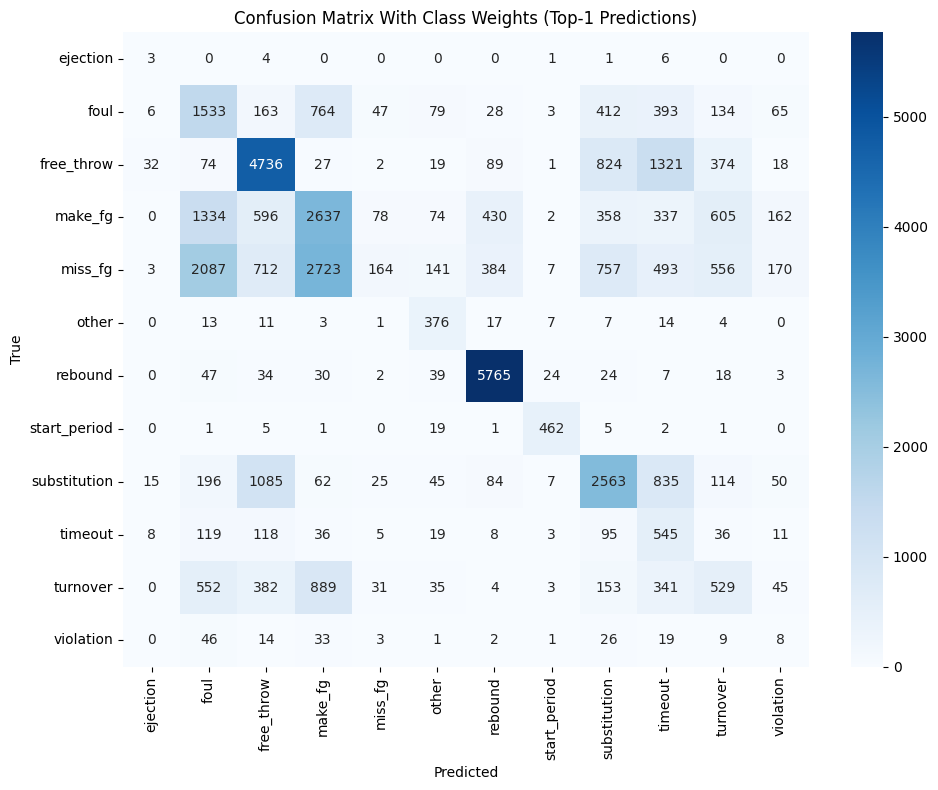

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Invert label mapping for correct ordering
idx_to_label = {v: k for k, v in label_to_idx.items()}
labels_ordered = [idx_to_label[i] for i in range(len(idx_to_label))]

# Confusion matrix using TOP-1 predictions
cm = confusion_matrix(all_true, all_top1_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels_ordered,
    yticklabels=labels_ordered
)

plt.title("Confusion Matrix With Class Weights (Top-1 Predictions)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


/tmp/ipython-input-339720485.py:9: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(epochs,train_losses, val_losses, label= ("Train loss", "Val loss"))


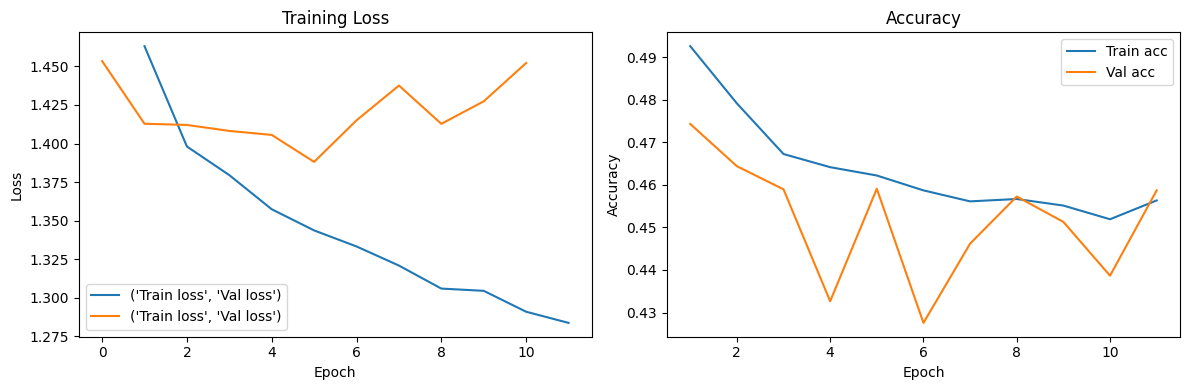

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 4))

# ---- loss ----
plt.subplot(1, 2, 1)
plt.plot(epochs,train_losses, val_losses, label= ("Train loss", "Val loss"))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# ---- accuracy ----
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Train acc")
plt.plot(epochs, val_accs,   label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## PART 2 COMPARING BASELINE LLM MODEL

In [ ]:
!pip install -q transformers accelerate torch


In [ ]:
from transformers import pipeline
import torch

llm = pipeline(
    "text-generation",
    model="mistralai/Mistral-7B-Instruct-v0.2",
    torch_dtype=torch.float16,
    device_map="auto"
)

# REQUIRED for batching
llm.tokenizer.pad_token = llm.tokenizer.eos_token
llm.tokenizer.pad_token_id = llm.tokenizer.eos_token_id


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0


In [ ]:
GAT_LABELS = [
    "make_fg",
    "miss_fg",
    "free_throw",
    "rebound",
    "turnover",
    "foul",
    "violation",
    "substitution",
    "timeout",
    "jumpball",
    "ejection",
    "start_period",
    "other"
]

label_to_idx = {l: i for i, l in enumerate(GAT_LABELS)}
idx_to_label = {i: l for l, i in label_to_idx.items()}


In [ ]:
def graph_to_text(g):
    row = g["event_row"]

    time_left = row.get("PCTIMESTRING", "unknown")
    margin = row.get("SCOREMARGIN", "unknown")

    desc = (
        str(row.get("HOMEDESCRIPTION") or "") + " " +
        str(row.get("VISITORDESCRIPTION") or "")
    ).strip()

    return f"Time left: {time_left}, margin: {margin}. {desc}"


In [ ]:
def build_llm_prompt(play_text):
    return f"""
You are given a basketball play description.

{play_text}

What is the most likely NEXT action?

Choose exactly ONE label from:
{', '.join(GAT_LABELS)}

Answer with only the label.
"""


In [ ]:
MAX_LLM_SAMPLES = 10000   # adjust as needed

texts = [
    build_llm_prompt(graph_to_text(g))
    for g in val_graphs[:MAX_LLM_SAMPLES]
]

outputs = llm(
    texts,
    max_new_tokens=8,
    do_sample=False,
    temperature=0.0,
    batch_size=32
)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

In [ ]:
def extract_topk_labels(text, labels, k=3):
    found = []
    for lab in labels:
        if lab in text and lab not in found:
            found.append(lab)
    if len(found) == 0:
        return ["other"] * k
    while len(found) < k:
        found.append(found[-1])
    return found[:k]


In [ ]:
llm_top1 = []
llm_top3 = []
llm_true = []

for out, true_lab in zip(outputs, val_labels[:MAX_LLM_SAMPLES]):
    full = out[0]["generated_text"].lower()
    answer = full.split("answer with only the label")[-1]

    top3 = extract_topk_labels(answer, GAT_LABELS, k=3)

    llm_top1.append(label_to_idx[top3[0]])
    llm_top3.append([label_to_idx[l] for l in top3])
    llm_true.append(label_to_idx[true_lab])


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

llm_true = np.array(llm_true)
llm_top1 = np.array(llm_top1)
llm_top3 = np.array(llm_top3)

top1_acc = accuracy_score(llm_true, llm_top1)

top3_acc = np.mean(
    [llm_true[i] in llm_top3[i] for i in range(len(llm_true))]
)

macro_f1 = f1_score(
    llm_true,
    llm_top1,
    average="macro",
    zero_division=0
)

print(f"LLM Zero-Shot Top-1 Accuracy : {top1_acc:.4f}")
print(f"LLM Zero-Shot Top-3 Accuracy : {top3_acc:.4f}")
print(f"LLM Zero-Shot Macro F1       : {macro_f1:.4f}")


LLM Zero-Shot Top-1 Accuracy : 0.0786
LLM Zero-Shot Top-3 Accuracy : 0.0856
LLM Zero-Shot Macro F1       : 0.0985


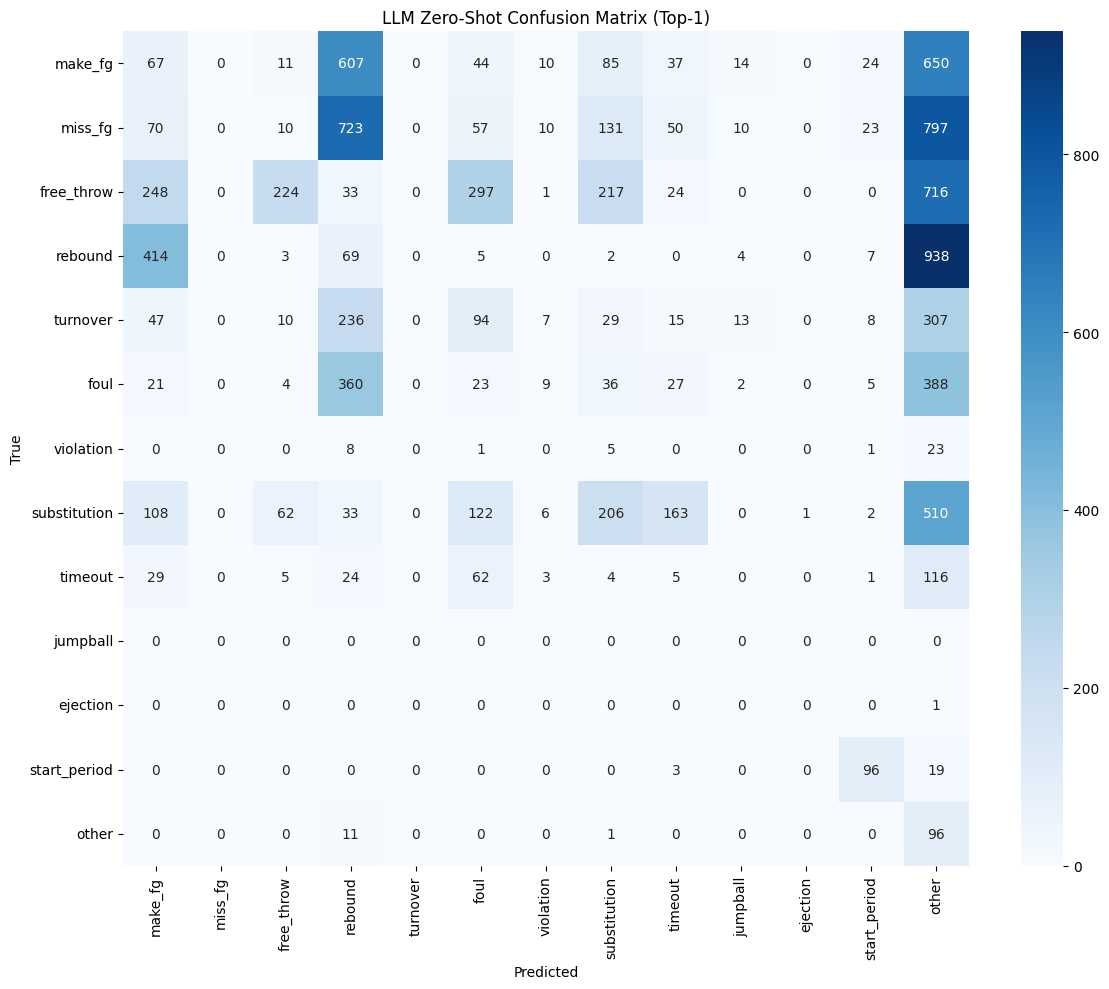

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_zeroshot = confusion_matrix(
    llm_true,
    llm_top1,
    labels=list(range(len(GAT_LABELS)))
)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_zeroshot,
    xticklabels=GAT_LABELS,
    yticklabels=GAT_LABELS,
    cmap="Blues",
    annot=True,
    fmt="d"
)

plt.title("LLM Zero-Shot Confusion Matrix (Top-1)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


FEW SHOT

In [ ]:
# FEW SHOT

FEW_SHOT_EXAMPLES = """
Example 1:
Time left: 6:12, margin: Lakers +2.
LeBron James makes a layup.
Next action: make_fg

Example 2:
Time left: 4:55, margin: Celtics -1.
Jayson Tatum misses a three-pointer.
Al Horford grabs the rebound.
Next action: rebound

Example 3:
Time left: 3:40, margin: Heat +5.
Jimmy Butler is fouled on the drive.
Next action: foul

Example 4:
Time left: 2:18, margin: Bucks +7.
Giannis Antetokounmpo misses a free throw.
Next action: free_throw

Example 5:
Time left: 1:02, margin: Suns +1.
Chris Paul commits a bad pass turnover.
Next action: turnover

Example 6:
Time left: 8:00, margin: 0.
Start of the 2nd quarter.
Next action: start_period
"""


In [ ]:
def build_llm_prompt_fewshot(play_text):
    return f"""
You are given a basketball play description.
Your task is to predict the MOST LIKELY NEXT action.

Possible labels:
{', '.join(GAT_LABELS)}

{FEW_SHOT_EXAMPLES}

Now predict the next action.

Play:
{play_text}

Answer with ONLY ONE label from the list above.
"""


In [ ]:
def llm_predict_fewshot(play_text):
    prompt = build_llm_prompt_fewshot(play_text)

    out = llm(
        prompt,
        max_new_tokens=8,
        do_sample=False,
        temperature=0.0
    )[0]["generated_text"].lower()

    # only look after the final instruction
    answer = out.split("answer with only one label")[-1]

    for label in GAT_LABELS:
        if label in answer:
            return label

    return "other"


In [ ]:
def extract_topk_labels(text, labels, k=3):
    text = text.lower()
    found = []

    for label in labels:
        if label in text:
            found.append(label)

    # pad with "other" if needed
    while len(found) < k:
        found.append("other")

    return found[:k]


In [ ]:
texts = []
MAX_LLM_SAMPLES = 10000

for g in val_graphs[:MAX_LLM_SAMPLES]:
    texts.append(
        build_llm_prompt_fewshot(graph_to_text(g))
    )

outputs = llm(
    texts,
    max_new_tokens=8,
    do_sample=False,
    temperature=0.0,
    batch_size=32
)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

In [ ]:
llm_top1 = []
llm_top3 = []
llm_true = []

for out, true_lab in zip(outputs, val_labels[:MAX_LLM_SAMPLES]):
    full = out[0]["generated_text"].lower()
    answer = full.split("answer with only one label")[-1]

    top3_labels = extract_topk_labels(answer, GAT_LABELS, k=3)

    llm_top1.append(label_to_idx[top3_labels[0]])
    llm_top3.append([label_to_idx[l] for l in top3_labels])
    llm_true.append(label_to_idx[true_lab])


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

llm_true = np.array(llm_true)
llm_top1 = np.array(llm_top1)
llm_top3 = np.array(llm_top3)

top1_acc = accuracy_score(llm_true, llm_top1)

top3_acc = np.mean(
    [(llm_true[i] in llm_top3[i]) for i in range(len(llm_true))]
)

macro_f1 = f1_score(
    llm_true,
    llm_top1,
    average="macro",
    zero_division=0
)

print(f"LLM Top-1 Accuracy : {top1_acc:.4f}")
print(f"LLM Top-3 Accuracy : {top3_acc:.4f}")
print(f"LLM Macro F1       : {macro_f1:.4f}")


LLM Top-1 Accuracy : 0.0779
LLM Top-3 Accuracy : 0.1133
LLM Macro F1       : 0.0462


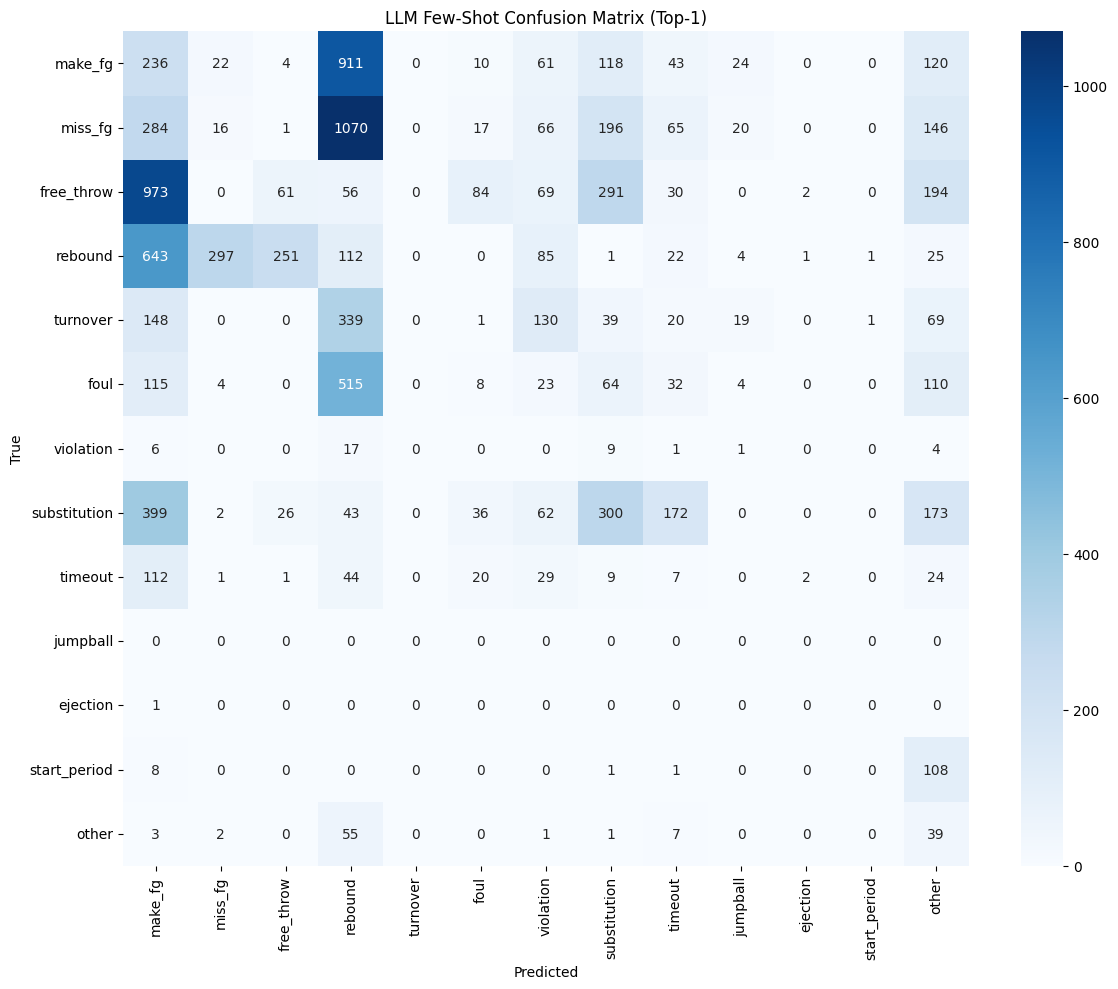

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_fewshot = confusion_matrix(
    llm_true,
    llm_top1,
    labels=list(range(len(GAT_LABELS)))
)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_fewshot,
    xticklabels=GAT_LABELS,
    yticklabels=GAT_LABELS,
    cmap="Blues",
    annot=True,
    fmt="d"
)

plt.title("LLM Few-Shot Confusion Matrix (Top-1)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
